<a href="https://colab.research.google.com/github/Layantt/Data-Science-Project/blob/main/DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing and Cleaning

In [62]:
# Required Libraries Installation
import subprocess, sys, os, re
from datetime import datetime

def install_packages():
    packages = ["requests", "beautifulsoup4", "pandas", "lxml", "urllib3", "certifi"]
    for package in packages:
        try:
            __import__(package.replace("beautifulsoup4", "bs4"))
        except ImportError:
            subprocess.run([sys.executable, "-m", "pip", "install", package], check=True)

install_packages()

# Imports
import requests, pandas as pd
import certifi
from bs4 import BeautifulSoup
from google.colab import files
from pathlib import Path
import urllib3

# Disable only the SSL warning if we fall back to verify=False
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Output dir
output_dir = Path("raw_data")
output_dir.mkdir(exist_ok=True)
html_file = output_dir / "pdpl_raw_html.html"
csv_file  = output_dir / "pdpl_articles_enhanced.csv"

url = "https://laws.boe.gov.sa/boelaws/laws/lawdetails/b7cfae89-828e-4994-b167-adaa00e37188/1"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"}

print("Starting enhanced data collection with article status detection...")

def fetch_with_fallback(url, headers, timeout=30):
    """
    1) Try with default CA bundle (secure)
    2) Try with certifi.where() (explicit CA path)
    3) Last resort: verify=False (insecure, but pragmatic for Colab scraping)
    """
    try:
        r = requests.get(url, headers=headers, timeout=timeout)  # default
        r.raise_for_status()
        return r, "secure-default"
    except Exception as e1:
        try:
            r = requests.get(url, headers=headers, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r, "secure-certifi"
        except Exception as e2:
            # Final fallback (NOT for prod; just to proceed in Colab)
            r = requests.get(url, headers=headers, timeout=timeout, verify=False)
            r.raise_for_status()
            return r, "insecure-fallback"

try:
    response, mode = fetch_with_fallback(url, headers)
    print(f"HTTP GET OK via mode: {mode} | status={response.status_code}")

    # Save raw HTML for inspection
    html_file.write_text(response.text, encoding="utf-8")
    print(f"Raw HTML saved: {html_file}")

    soup = BeautifulSoup(response.text, "lxml")

    # Try structured extraction first
    articles_from_html = []
    article_divs = soup.find_all("div", class_="article_item")

    if article_divs:
        print(f"Found {len(article_divs)} article divs in HTML structure")
        for div in article_divs:
            classes = div.get("class", [])
            if "changed-article" in classes:
                article_status = "معدلة"
            elif "no_alternate" in classes:
                article_status = "أصلية"
            else:
                article_status = "غير محدد"

            title_element = div.find("h3")
            article_title = title_element.get_text(strip=True) if title_element else "عنوان غير محدد"

            content_div = div.find("div", class_="HTMLContainer")
            if content_div:
                article_text = content_div.get_text(separator=" ", strip=True)
                modification_text = "لا يوجد نص معدل"

                if article_status == "معدلة":
                    popup_div = div.find("div", class_="article_item_popup")
                    if popup_div:
                        popup_content = popup_div.find("div", class_="HTMLContainer")
                        if popup_content:
                            popup_text = popup_content.get_text(separator=" ", strip=True)
                            if popup_text and len(popup_text) > 10:
                                modification_text = popup_text
                        else:
                            popup_text = popup_div.get_text(separator=" ", strip=True)
                            if popup_text and len(popup_text) > 10:
                                modification_text = popup_text

                if article_text and len(article_text) > 10:
                    articles_from_html.append({
                        "article_title": article_title,
                        "article_text": article_text,
                        "article_status": article_status,
                        "modification_text": modification_text
                    })

    # Fallback to text parsing if needed
    articles_from_text = []
    if not articles_from_html:
        print("No structured HTML found, falling back to text extraction...")
        text = soup.get_text(separator="\n", strip=True)
        lines = text.split("\n")
        current_article, current_content, article_found = None, [], False

        for line in lines:
            line = line.strip()
            if not line:
                continue
            if re.match(r"^المادة\s+", line):
                if current_article and current_content and article_found:
                    article_text = " ".join(current_content).strip()
                    if len(article_text) > 10:
                        article_status = "أصلية"
                        modification_text = "لا يوجد نص معدل"
                        if any(ind in article_text for ind in ["عُدلت هذه المادة", "المرسوم الملكي", "بموجب", "معدلة"]):
                            article_status = "معدلة"
                            patterns = [
                                r'عُدلت هذه المادة.*?"(.*?)"',
                                r'بموجب.*?المرسوم الملكي.*?(.*?)(?:\.|$)',
                                r'لتكون بالنص الآتي.*?"(.*?)"'
                            ]
                            for pattern in patterns:
                                m = re.search(pattern, article_text, re.DOTALL)
                                if m:
                                    modification_text = m.group(1).strip()
                                    break
                            if modification_text == "لا يوجد نص معدل":
                                mod_start = article_text.find("عُدلت هذه المادة")
                                if mod_start != -1:
                                    modification_text = article_text[mod_start:mod_start+200] + "..."

                        articles_from_text.append({
                            "article_title": current_article,
                            "article_text": article_text,
                            "article_status": article_status,
                            "modification_text": modification_text
                        })
                current_article, current_content, article_found = line, [], True
            else:
                if current_article and article_found:
                    if len(line) <= 3:
                        continue
                    skip_line = False
                    if (line.startswith("تاريخ") or line.startswith("رقم") or
                        line.startswith("الجريدة الرسمية") or line.startswith("*") or line.startswith("-")):
                        skip_line = True
                    admin_only = ["تعديلات المادة", "مادة معدلة", "مادة ملغية"]
                    line_lower = line.lower()
                    for pat in admin_only:
                        if pat in line_lower and len(line) < 150 and line.count('.') <= 1:
                            skip_line = True
                            break
                    if not skip_line:
                        current_content.append(line)

        if current_article and current_content and article_found:
            article_text = " ".join(current_content).strip()
            if len(article_text) > 10:
                article_status = "أصلية"
                modification_text = "لا يوجد نص معدل"
                if any(ind in article_text for ind in ["عُدلت هذه المادة", "المرسوم الملكي", "بموجب", "معدلة"]):
                    article_status = "معدلة"
                    patterns = [
                        r'عُدلت هذه المادة.*?"(.*?)"',
                        r'بموجب.*?المرسوم الملكي.*?(.*?)(?:\.|$)',
                        r'لتكون بالنص الآتي.*?"(.*?)"'
                    ]
                    for pattern in patterns:
                        m = re.search(pattern, article_text, re.DOTALL)
                        if m:
                            modification_text = m.group(1).strip()
                            break
                    if modification_text == "لا يوجد نص معدل":
                        mod_start = article_text.find("عُدلت هذه المادة")
                        if mod_start != -1:
                            modification_text = article_text[mod_start:mod_start+200] + "..."

                articles_from_text.append({
                    "article_title": current_article,
                    "article_text": article_text,
                    "article_status": article_status,
                    "modification_text": modification_text
                })

    # Prefer HTML-based; else text-based; else empty
    articles = articles_from_html if articles_from_html else articles_from_text

    # Build DataFrame (even if empty, but with columns)
    cols = ["article_title", "article_text", "article_status", "modification_text"]
    df = pd.DataFrame(articles, columns=cols)

    # Basic cleaning
    if not df.empty:
        df = df[df["article_text"].astype(str).str.len() > 10]
        df = df.drop_duplicates(subset=["article_title"])
        first_articles = df[df["article_title"].astype(str).str.contains("المادة الأولى|المادة \\(1\\)|المادة ١", case=False, na=False, regex=True)]
        if len(first_articles) > 1:
            print("Detected duplicate first article - fixing...")
            best_first = first_articles.loc[first_articles["article_text"].str.len().idxmax()]
            df = df[~df["article_title"].str.contains("المادة الأولى|المادة \\(1\\)|المادة ١", case=False, na=False, regex=True)]
            df = pd.concat([pd.DataFrame([best_first]), df]).reset_index(drop=True)

    # Always write a CSV so Cell 2 never fails with FileNotFound
    df.to_csv(csv_file, index=False, encoding="utf-8-sig")
    print(f"Successfully extracted {len(df)} articles with status information!")
    print(f"Enhanced data saved to: {csv_file}")

    # Quick stats
    print("CWD:", Path.cwd())
    print("raw_data contents:", [p.name for p in output_dir.iterdir()])

    if not df.empty:
        print("\n Article Status Summary:")
        print("-" * 40)
        for status, count in df['article_status'].value_counts().items():
            print(f"• {status}: {count} مادة")

except Exception as e:
    # As a last resort, create an empty CSV with columns so Cell 2 won't crash
    print(f" Error in data collection: {e}")
    if not csv_file.exists():
        pd.DataFrame(columns=["article_title", "article_text", "article_status", "modification_text"]).to_csv(csv_file, index=False, encoding="utf-8-sig")
        print("Created empty CSV due to error, to keep the pipeline alive.")

print("\n Files saved in directory:", output_dir)
print(" Enhanced data collection completed (with fallbacks).")
try:
    files.download(str(html_file))
    files.download(str(csv_file))
except:
    print(" Files ready for download in the output directory")


Starting enhanced data collection with article status detection...
HTTP GET OK via mode: insecure-fallback | status=200
Raw HTML saved: raw_data/pdpl_raw_html.html
Found 43 article divs in HTML structure
Successfully extracted 43 articles with status information!
Enhanced data saved to: raw_data/pdpl_articles_enhanced.csv
CWD: /content
raw_data contents: ['pdpl_cleaned.csv', 'pdpl_articles_enhanced.csv', 'pdpl_raw_html.html']

 Article Status Summary:
----------------------------------------
• معدلة: 24 مادة
• أصلية: 19 مادة

 Files saved in directory: raw_data
 Enhanced data collection completed (with fallbacks).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
from pathlib import Path
import pandas as pd

base = Path("raw_data")
print("CWD:", Path.cwd())
print("raw_data contents:", [p.name for p in base.glob("*")])

target = base / "pdpl_articles_enhanced.csv"
if not target.exists():
    raise FileNotFoundError("CSV not found. Re-run Cell 1 successfully first.")

# ترميز utf-8-sig
df = pd.read_csv(target, encoding="utf-8-sig")
print("Loaded file:", target)
print("Initial shape:", df.shape)
df.info()

# checking out
display(df.head(2))


CWD: /content
raw_data contents: ['pdpl_cleaned.csv', 'pdpl_articles_enhanced.csv', 'pdpl_raw_html.html']
Loaded file: raw_data/pdpl_articles_enhanced.csv
Initial shape: (43, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_title      43 non-null     object
 1   article_text       43 non-null     object
 2   article_status     43 non-null     object
 3   modification_text  43 non-null     object
dtypes: object(4)
memory usage: 1.5+ KB


,article_title,article_text,article_status,modification_text
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,معدلة,- صدر المرسوم الملكي رقم (م/148) وتاريخ 1444/9...
1,المادة الثانية,يُطبق النظام على أي عملية مُعالجة لبيانات شخصي...,أصلية,لا يوجد نص معدل


In [64]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated(subset=["article_title"]).sum()
print(f"\nDuplicate articles found: {duplicates}")

# Display sample
df.head()



Missing values per column:
article_title        0
article_text         0
article_status       0
modification_text    0
dtype: int64

Duplicate articles found: 0


,article_title,article_text,article_status,modification_text
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,معدلة,- صدر المرسوم الملكي رقم (م/148) وتاريخ 1444/9...
1,المادة الثانية,يُطبق النظام على أي عملية مُعالجة لبيانات شخصي...,أصلية,لا يوجد نص معدل
2,المادة الثالثة,لا تخل الأحكام والإجراءات المنصوص عليها في الن...,أصلية,لا يوجد نص معدل
3,المادة الرابعة,يكون لصاحب البيانات الشخصية -وفقاً للأحكام الو...,معدلة,- عُدلت هذه المادة وذلك بموجب المرسوم الملكي ر...
4,المادة الخامسة,فيما عدا الأحوال المنصوص عليها في النظام، لا ت...,معدلة,"- إحلال كلمة ""صريحة"" محل كلمة ""كتابية"" الواردة..."


In [65]:
import re

def clean_text(text):
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove non-Arabic or special symbols if any
    text = re.sub(r'[^\u0600-\u06FF\s.,؛:،]', '', text)
    return text.strip()

# Apply cleaning
df["article_text"] = df["article_text"].apply(clean_text)
df["modification_text"] = df["modification_text"].apply(clean_text)


In [66]:
# Normalize status column to ensure consistency
df["article_status"] = df["article_status"].replace({
    "معدلة": "Modified",
    "أصلية": "Original",
    "غير محدد": "Unknown"
})


In [67]:
# Save the cleaned and processed dataset
cleaned_file = "raw_data/pdpl_cleaned.csv"
df.to_csv(cleaned_file, index=False, encoding="utf-8-sig")

print(f" Cleaned dataset saved to: {cleaned_file}")


 Cleaned dataset saved to: raw_data/pdpl_cleaned.csv


# Exploratory Data Analysis (EDA):

#### in this section we'll show:

1. Statistical Patterns
2. Visualizations
3. Text Correlations
4. Metadata Review
5. Bias Awareness


 ## 1. Statistical Summaries (Uncover patterns, trends, and anomalies):

In [68]:
df = pd.read_csv('raw_data/pdpl_cleaned.csv')
# exploring the table
df.info()
print('========================================================')
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_title      43 non-null     object
 1   article_text       43 non-null     object
 2   article_status     43 non-null     object
 3   modification_text  43 non-null     object
dtypes: object(4)
memory usage: 1.5+ KB


,article_title,article_text,article_status,modification_text
count,43,43,43,43
unique,43,43,2,25
top,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,Modified,لا يوجد نص معدل
freq,1,1,24,19


In [69]:
# calculating the texts length


df['text_length'] = df['article_text'].str.len()
print(df['text_length'])
print('========================================================')
print(df['text_length'].describe())

0     3112
1      531
2      175
3      902
4      467
5      407
6      199
7      543
8      598
9     1113
10     648
11     320
12     848
13     159
14     667
15     690
16     342
17     649
18     176
19     368
20     143
21     177
22     483
23     502
24     571
25     171
26     513
27     196
28    1119
29     807
30     559
31     799
32     716
33     210
34     806
35     928
36     216
37     597
38     246
39     227
40     141
41     301
42      70
Name: text_length, dtype: int64
count      43.000000
mean      544.465116
std       488.360198
min        70.000000
25%       213.000000
50%       502.000000
75%       678.500000
max      3112.000000
Name: text_length, dtype: float64


In [70]:
# calculate how many words in the article text column

df['word_count'] = df['article_text'].apply(lambda x: len(x.split()))
print(df['word_count'].describe())

count     43.000000
mean      91.395349
std       80.835854
min       12.000000
25%       35.500000
50%       83.000000
75%      113.500000
max      508.000000
Name: word_count, dtype: float64


In [71]:
# most repetitive words
# using pandas

pd.Series(tokens).value_counts().head(20)


,count
أو,173
من,123
البيانات,112
في,99
الشخصية,99
على,93
النظام,58
جهة,54
التحكم,48
اللوائح,45


In [72]:
# show the outliers

threshold_high = df['word_count'].quantile(0.95)
threshold_low = df['word_count'].quantile(0.05)

df_outliers = df[(df['word_count'] < threshold_low) | (df['word_count'] > threshold_high)]

# print(df_outliers) {too messy}

# to make output more clear
df_outliers.style.set_caption("Outliers in word count")


,article_title,article_text,article_status,modification_text,text_length,word_count
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارات الآتية أينما وردت في هذا النظام المعاني المبينة أمام كل منها، ما لم يقتضِ السياق غير ذلك: النظام: نظام حماية البيانات الشخصية. اللوائح: اللوائح التنفيذية للنظام. الجهة المختصة: الجهة التي يصدر بتحديدها قرار من مجلس الوزراء. البيانات الشخصية: كل بيان مهما كان مصدره أو شكله من شأنه أن يؤدي إلى معرفة الفرد على وجه التحديد، أو يجعل التعرف عليه ممكنًا بصفة مباشرة أو غير مباشرة، ومن ذلك: الاسم، ورقم الهوية الشخصية، والعناوين، وأرقام التواصل، وأرقام الرُّخص والسجلات والممتلكات الشخصية، وأرقام الحسابات البنكية والبطاقات الائتمانية، وصور الفرد الثابتة أو المتحركة، وغير ذلك من البيانات ذات الطابع الشخصي. المُعالجة: أي عملية تُجرى على البيانات الشخصية بأي وسيلة كانت يدوية أو آلية، ومن ذلك: عمليات الجمع، والتسجيل، والحفظ، والفهرسة، والترتيب، والتنسيق، والتخزين، والتعديل، والتحديث، والدمج، والاسترجاع، والاستعمال، والإفصاح، والنقل، والنشر، والمشاركة في البيانات أو الربط البيني، والحجب، والمسح، والإتلاف. الجمع: حصول جهة التحكم على البيانات الشخصية وفقاً لأحكام النظام، سواء من صاحبها مُباشرةً أو ممن يُمثله أو ممن له الولاية الشرعية عليه أو من طرف آخر. الإتلاف: كل عمل يؤدي إلى إزالة البيانات الشخصية ويجعل من المتعذر الاطلاع عليها أو استعادتها مرة أخرى. الإفصاح: تمكين أي شخص عدا جهة التحكم من الحصول على البيانات الشخصية أو استعمالها أو الاطلاع عليها بأي وسيلة ولأي غرض. النقل: نقل البيانات الشخصية من مكان إلى آخر لمعالجتها. النشر: بث أي من البيانـات الشخصية عبـر وسيلـة نشـر مقـروءة أو مسموعـة أو مرئية، أو إتاحتها. البيانات الحساسة: كل بيان شخصي يتضمن الإشارة إلى أصل الفرد العرقي أو أصله القبلي، أو معتقده الديني أو الفكري أو السياسي، أو يدل على عضويته في جمعيات أو مؤسسات أهلية. وكذلك البيانات الجنائية والأمنية، أو بيانات السمات الحيوية التي تحدد الهوية، أو البيانات الوراثية، أو البيانات الائتمانية، أو البيانات الصحية، وبيانات تحديد الموقع، والبيانات التي تدل على أن الفرد مجهول الأبوين أو أحدهما. البيانات الوراثية: كل بيان شخصي يتعلق بالخصائص الوراثية أو المكتسبة لشخص طبيعي، يحدد بشكل فريد السمات الفيسيولوجية أو الصحية لذلك الشخص، ويستخلص من تحليل عينة بيولوجية للشخص كتحليل الأحماض النووية أو تحليل أي عينة أخرى تؤدي إلى استخلاص بيانات وراثية. البيانات الصحية: كل بيان شخصي يتعلق بحالة الفرد الصحية، سواء الجسدية أو العقلية أو النفسية أو المتعلقة بالخدمات الصحية الخاصة به. الخدمات الصحية: الخدمات المتعلقة بصحة الفرد، ومن ذلك الخدمات الوقائية والعلاجية والتأهيلية والتنويم وتوفير الدواء. البيانات الائتمانية: كل بيان شخصي يتعلق بطلب الفرد الحصول على تمويل، أو حصوله عليه، سواء لغرض شخصي أو عائلي، من جهة تُمارس التمويل، بما في ذلك أي بيان يتعلق بقدرته على الحصول على ائتمان أو بقدرته على الوفاء به أو بتاريخه الائتماني. صاحب البيانات الشخصية: الفرد الذي تتعلق به البيانات الشخصية أو من يمثله أو من له الولاية الشرعية عليه. الجهة العامة: أي وزارة أو مصلحة أو مؤسسة عامة أو هيئة عامة، أو أي جهة عامة مستقلة في المملكة، أو أي من الجهات التابعة لها. جهة التحكم: أي جهة عامة، وأي شخصية ذات صفة طبيعية أو اعتبارية خاصة؛ تحدد الغرض من معالجة البيانات الشخصية وكيفية ذلك؛ سواء أباشرت معالجة البيانات بوساطتها أم بوساطة جهة المعالجة. جهة المعالجة: أي جهة عامة، وأي شخصية ذات صفة طبيعية أو اعتبارية خاصة؛ تعالج البيانات الشخصية لمصلحة جهة التحكم ونيابةً عنها.,Modified,صدر المرسوم الملكي رقم م وتاريخ هـ، وذلك بتعديل التعريفات الآتية: الإتلاف ، الإفصاح ، البيانات الحساسة ، صاحب البيانات الشخصية وتكون على النحو الآتي: الإتلاف: أي إجراء يتم على البيانات الشخصية ويجعل من المتعذر الاطلاع عليها أو استعادتها مرة أخرى أو معرفة صاحبها على وجه التحديد . الإفصاح: تمكين أي شخص عدا جهة التحكم أو جهة المعالجة بحسب الأحوال من الحصول على البيانات الشخصية أو استعمالها أو الاطلاع عليها بأي وسيلة ولأي غرض . البيانات الحساسة: كل بيان شخصي يتعلق بأصل الفرد العرقي أو أصله الإثني، أو معتقده الديني أو الفكري أو السياسي. وكذلك البيانات الأمنية والجنائية، أو بيانات السمات الحيوية التي تحدد الهوية، أو البيانات الوراثية، أو البيانات الصحية، والبيانات التي تدل على أن الفرد مجهول الأبوين أو أحدهما . صاحب البيانات الشخصية: الفرد الذي تتعلق به البيانات الشخصية .,3

## 2. Visualization:

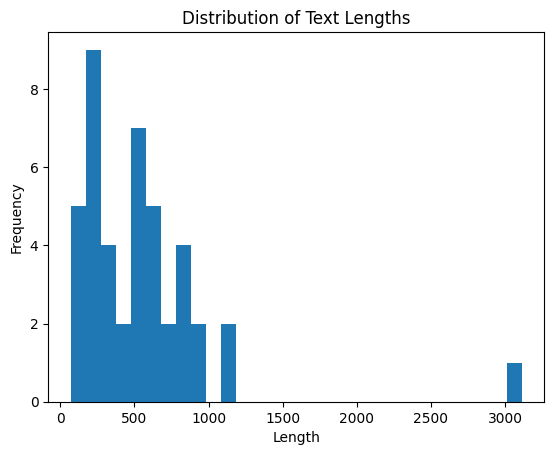

In [73]:
# Histogram for texts length
import matplotlib.pyplot as plt

plt.hist(df['text_length'], bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

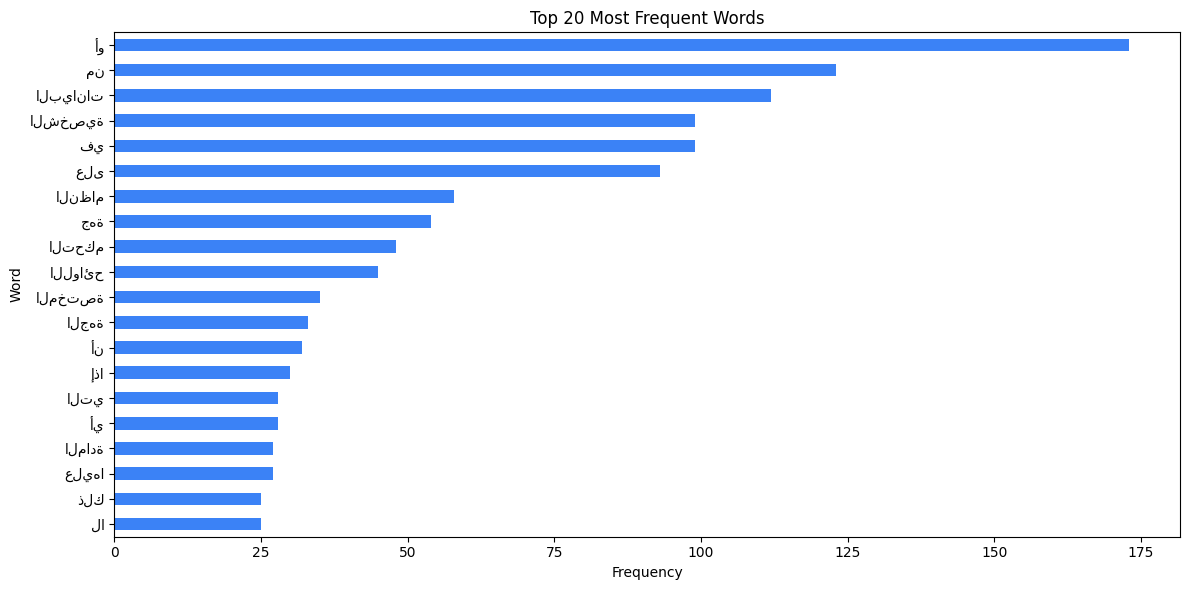

In [74]:
# Bar Plot for most repetitive words:


text = " ".join(df['article_text'].astype(str))
tokens = re.findall(r"\w+", text, flags=re.UNICODE)

word_freq = pd.Series(tokens).value_counts().head(20)

plt.figure(figsize=(12,6))
word_freq.sort_values().plot(kind='barh', color='#3b82f6')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

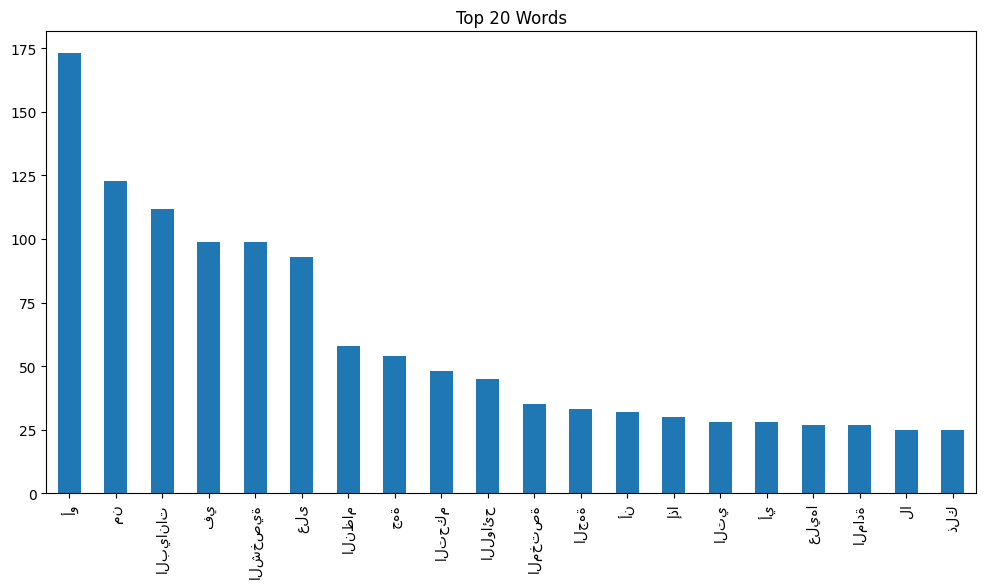

In [75]:
freq = pd.Series(dict(Counter(tokens))).sort_values(ascending=False)[:20]
freq.plot(kind='bar', figsize=(12,6))
plt.title('Top 20 Words')
plt.show()


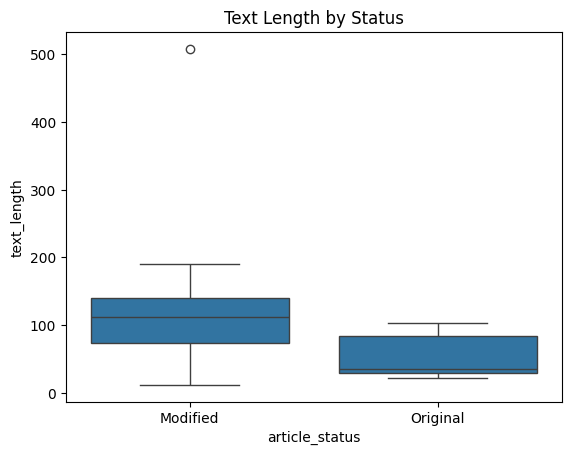

In [76]:
# Boxplot لطول النصوص حسب حالة المادة
import seaborn as sns

df['text_length'] = df['article_text'].apply(lambda x: len(str(x).split())) # add the column text len

sns.boxplot(x='article_status', y='text_length', data=df)
plt.title('Text Length by Status')
plt.show()

## 3. Correlation / Relationships analysis

In [80]:
import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

assert {'article_text','article_status'}.issubset(df.columns), "Expected columns missing."
df = df.copy()

#Tokenizer
def tokenize_ar(text):
    return re.findall(r"\w+", str(text), flags=re.UNICODE)

AR_STOP = {
    'من','في','على','و','او','أو','إلى','الى','أن','إن','لا','ما','عن','مع','هذا','هذه','ذلك','تلك',
    'هو','هي','ها','هما','هم','هن','أ','يا','كل','أي','أيضاً','قد','كما','لكن','بل','ثم','لدى',
    'لها','له','لهم','لهن','كان','كانت','يكون','تكون','كون','هناك','هنا','حتى','اذا','إذا','بما','ومن','فإن'
}

if 'text_length' not in df.columns:
    df['text_length'] = df['article_text'].apply(lambda x: len(str(x)))
if 'word_count' not in df.columns:
    df['word_count'] = df['article_text'].apply(lambda x: len(tokenize_ar(x)))

print("=== Length / Count by Status ===")
display(df.groupby('article_status')[['word_count','text_length']].agg(['mean','median','min','max','std']).round(2))

# Top words per status ( after removing stopwords)
print("\n=== Top Words per Status (stopwords removed) ===")
for status in df['article_status'].unique():
    subset = df[df['article_status'] == status]
    toks = []
    for t in subset['article_text']:
        toks.extend(tokenize_ar(t))
    toks = [w for w in toks if w not in AR_STOP and len(w) > 1]
    top = Counter(toks).most_common(15)
    top_df = pd.DataFrame(top, columns=['word','count'])
    print(f"\n[Status = {status}]")
    display(top_df)

#TF-IDF:
print("\n=== TF-IDF Distinctive Terms per Status ===")
vectorizer = TfidfVectorizer(
    max_features=2000,
    analyzer='word',
    token_pattern=r'\w+',
    lowercase=False
)
X = vectorizer.fit_transform(df['article_text'])
vocab = np.array(vectorizer.get_feature_names_out())

mask_mod = (df['article_status'] == 'Modified').to_numpy()
mask_org = (df['article_status'] == 'Original').to_numpy()
idx_mod = np.where(mask_mod)[0]
idx_org = np.where(mask_org)[0]

if idx_mod.size > 0:
    mean_mod = np.asarray(X[idx_mod].mean(axis=0)).ravel()
else:
    mean_mod = np.zeros(X.shape[1])

if idx_org.size > 0:
    mean_org = np.asarray(X[idx_org].mean(axis=0)).ravel()
else:
    mean_org = np.zeros(X.shape[1])

def top_terms(mean_vec, k=15):
    idx = mean_vec.argsort()[::-1][:k]
    return pd.DataFrame({'term': vocab[idx], 'score': mean_vec[idx]})

print("\nTop TF-IDF terms (Modified):")
display(top_terms(mean_mod, 15))

print("\nTop TF-IDF terms (Original):")
display(top_terms(mean_org, 15))

diff = mean_mod - mean_org
print("\nMost distinctive FOR Modified (score = mean_mod - mean_org):")
idx_mod_rel = diff.argsort()[::-1][:15]
display(pd.DataFrame({'term': vocab[idx_mod_rel], 'score': diff[idx_mod_rel]}))

print("\nMost distinctive FOR Original (score = mean_org - mean_mod):")
idx_org_rel = (-diff).argsort()[::-1][:15]
display(pd.DataFrame({'term': vocab[idx_org_rel], 'score': (-diff)[idx_org_rel]}))

# Co-occurrence
print("\n=== Co-occurrence (Top word pairs across articles) ===")
pair_counts = defaultdict(int)
for text in df['article_text']:
    toks = [t for t in tokenize_ar(text) if t not in AR_STOP and len(t) > 1]
    if toks:
#reduce noise
        local_freq = Counter(toks).most_common(50)
        keep = sorted({w for w, _ in local_freq})
        for a, b in combinations(keep, 2):
            pair_counts[(a, b)] += 1

top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:15]
pairs_df = pd.DataFrame([(a, b, c) for (a, b), c in top_pairs], columns=['word_a','word_b','co_docs'])
display(pairs_df)

print("\n Correlation-style analysis complete.")


=== Length / Count by Status ===


word_count                        text_length                  \
                     mean median min  max    std        mean median min  max   
article_status                                                                 
Modified           123.46  112.0  12  508  94.08      123.46  112.0  12  508   
Original            50.89   35.0  22  103  28.92       50.89   35.0  22  103   

                       
                  std  
article_status         
Modified        94.08  
Original        28.92


=== Top Words per Status (stopwords removed) ===

[Status = Modified]


,word,count
0,البيانات,81
1,الشخصية,73
2,جهة,42
3,النظام,41
4,التحكم,38
5,اللوائح,31
6,الجهة,29
7,المختصة,29
8,التي,23
9,المادة,20



[Status = Original]


,word,count
0,البيانات,31
1,الشخصية,26
2,النظام,17
3,اللوائح,14
4,جهة,12
5,التحكم,10
6,معالجة,9
7,عليها,8
8,يجوز,8
9,المنصوص,7



=== TF-IDF Distinctive Terms per Status ===

Top TF-IDF terms (Modified):


,term,score
0,أو,0.133546
1,من,0.108474
2,في,0.093352
3,البيانات,0.085229
4,الشخصية,0.084634
5,على,0.078913
6,المختصة,0.060397
7,جهة,0.059144
8,الجهة,0.059042
9,التحكم,0.057358



Top TF-IDF terms (Original):


,term,score
0,أو,0.090124
1,البيانات,0.087373
2,الشخصية,0.077823
3,من,0.074402
4,على,0.068687
5,في,0.061990
6,النظام,0.057613
7,معالجة,0.050515
8,جهة,0.045132
9,اللوائح,0.043415



Most distinctive FOR Modified (score = mean_mod - mean_org):


,term,score
0,أو,0.043422
1,جمعها,0.039537
2,الجهة,0.038323
3,الغرض,0.037214
4,بياناته,0.034333
5,المختصة,0.034311
6,من,0.034072
7,في,0.031362
8,المعالجة,0.030335
9,الإفصاح,0.030156



Most distinctive FOR Original (score = mean_org - mean_mod):


,term,score
0,معالجة,0.038944
1,خدمة,0.023960
2,وتحدد,0.021790
3,تصوير,0.021607
4,نسخها,0.021607
5,المواد,0.021329
6,الضرر,0.021085
7,خلال,0.020784
8,جرى,0.020632
9,وسيلة,0.020570



=== Co-occurrence (Top word pairs across articles) ===


,word_a,word_b,co_docs
0,البيانات,الشخصية,33
1,البيانات,اللوائح,26
2,الشخصية,اللوائح,25
3,البيانات,النظام,23
4,البيانات,التحكم,22
5,البيانات,جهة,22
6,التحكم,الشخصية,22
7,الشخصية,جهة,22
8,الشخصية,النظام,21
9,اللوائح,النظام,21



 Correlation-style analysis complete.


## 4. Metadata Review

 #### The dataset used in this project was collected from the official Saudi Laws Portal managed by the Bureau of Experts at the Council of Ministers, which serves as the authoritative source of Saudi legal texts.

     Source: Saudi Laws Portal (https://laws.boe.gov.sa/boelaws/laws/lawdetails/b7cfae89-828e-4994-b167-adaa00e37188/1)

- Date Collected: September 2025

- Collection Method: Web scraping using Python libraries (requests, BeautifulSoup) to extract legal articles from the PDPL page. A raw HTML snapshot was stored for reproducibility.

- Language: Arabic

- Number of Records: 43 legal articles (19 original and 24 modified).

- Data Format: CSV (pdpl_articles_enhanced.csv and pdpl_cleaned.csv)

- Descriptive Statistics:

  - Average word count: ~91 words per article (min = 12, max = 508)

  - Average character length: ~544 characters (min = 70, max = 3112)

  - Most frequent words: “البيانات”، “الشخصية”، “جهة”، “التحكم”، “الجهة المختصة”

    *These statistics reveal a high variance in article length and linguistic concentration around specific legal terms, which reflects the formal language and structure of the PDPL. Such characteristics must be considered during analysis to avoid skewed interpretations.*

- Features:

  - article_title: Official title of each article.

  - article_text: Full legal text of each article.

  - article_status: Indicates whether the article is original, modified, or unknown.

  - modification_text: Amendment details if available.

  - category (added manually): Label assigned by the research team to classify articles thematically.

  - text_length: Number of characters in each article text.

  - word_count: Number of words in each article text.

**The primary data:**

manually added classification labels (category) created by the research team to support downstream applications such as legal Q&A generation.

**The secondary data:**

The original legal text sourced directly from the Saudi Laws Portal.

This metadata not only documents how the dataset was collected and structured but also provides analytical context that informs the EDA process and highlights potential biases and patterns in the legal text.

## 5. Bias Analysis


*The secondary dataset consists of 43 legal articles collected from the Saudi Laws Portal, with 24 modified articles and 19 original articles. Although the source is official and reliable, several biases can affect the interpretation of analytical results:*

1. **Source Bias**

All data originates from a single official governmental source, which reflects the formal legal language used by the state. This means it does not represent interpretations from other stakeholders such as legal practitioners, private institutions, or the public.

2. **Linguistic Bias**
The word frequency analysis showed heavy repetition of specific legal terms, such as:

“البيانات” (112 occurrences)

“الشخصية” (82 occurrences)

“جهة” (53 occurrences)

“التحكم” (37 occurrences)

“الجهة المختصة” (31 occurrences)
This repetition may dominate WordClouds and frequency plots, making other contextual words appear less significant — a common limitation in legal corpora.

3. **Distribution Bias**
The word count distribution is uneven:

Mean = 91 words

Min = 12 words (shortest article)

Max = 508 words (longest article)
Some articles are significantly longer than others (e.g., Article 1) and could skew average values or influence models trained on this data if not normalized properly.

4. **Temporal Bias**
The dataset reflects the PDPL as of September 2025. Since the law is subject to amendments, these findings might become outdated with future legal changes. This can affect the long-term validity of any derived insights.

5. **Collection Method Bias**
The dataset was collected via web scraping. Although validated, the extraction process depends on the structure of the web page (DOM). If this structure changes or if some content (e.g., popups) was missed, it could result in incomplete data.